# Load Libraries

To install these libraries use: ```pip install numpy matplotlib librosa```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

import librosa
import librosa.display

# Load Basic Music File

In [2]:
music_file = '../data/fma_small/000/000002.mp3'
y, sr = librosa.load(music_file)

/home/udo/anaconda3/envs/music/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


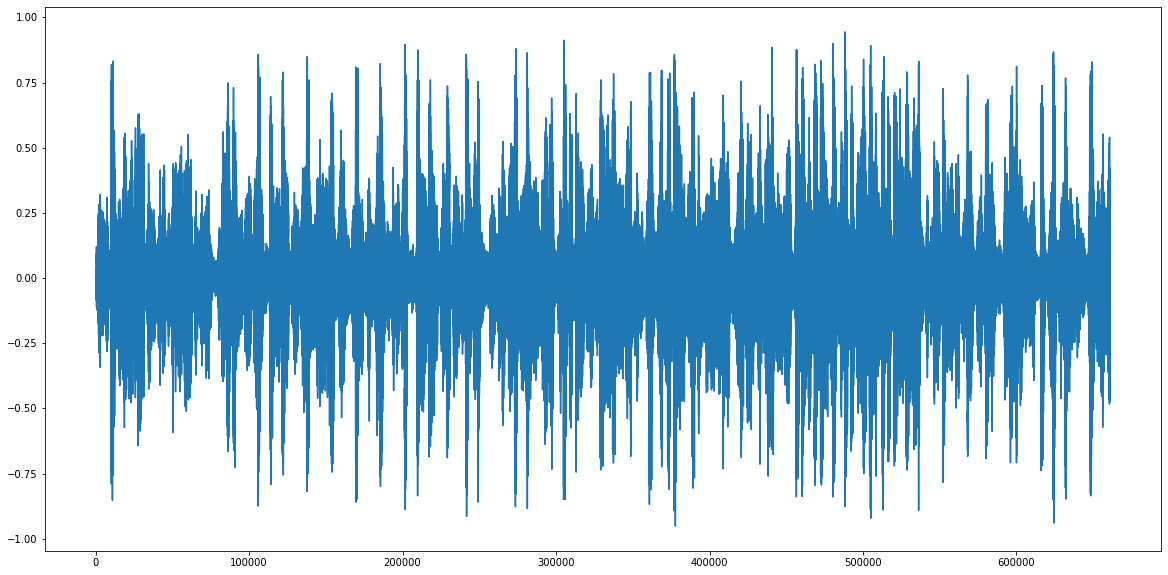

In [3]:
plt.plot(y)
plt.show()

# Calculate Low Level Features

Calculating features in librosa is quite easy.  
The library already provides a lot of different feature extraction algorithms.  
E.g., zero crossing rate, spectral bandwith, ...  
In most cases, you just need the extracted time series y.  
For more complex features like spectrograms and MFCCs, you also need the sr.

## Zero Crossing Rate

The zero crossing rate showing the sign change in an interval is just called with y.  
However, you can also change the frame to fine tune it on the data, you want to analyze.  
  
 https://librosa.org/doc/latest/generated/librosa.feature.zero_crossing_rate.html#librosa.feature.zero_crossing_rate

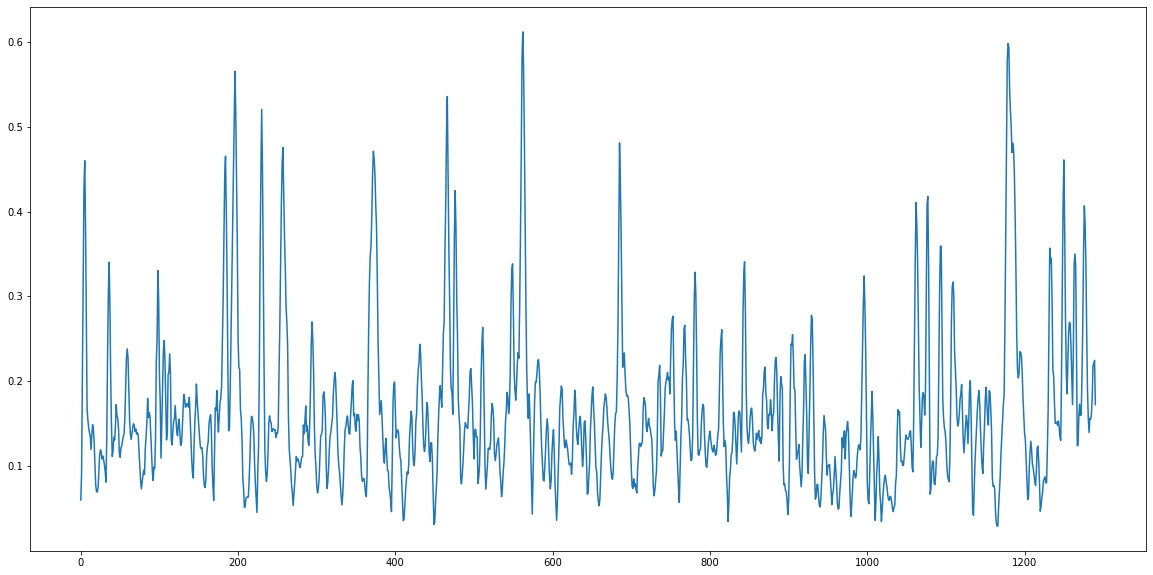

In [4]:
zcr = librosa.feature.zero_crossing_rate(y)

plt.plot(zcr[0])
plt.show()

## Beat detector

This is an example of beat detection provided by librosa also.  
In this case, you need the sampling rate, so be sure to also store sr.

https://librosa.org/doc/latest/generated/librosa.beat.beat_track.html#librosa.beat.beat_track

Estimated tempo: 161.50 beats per minute




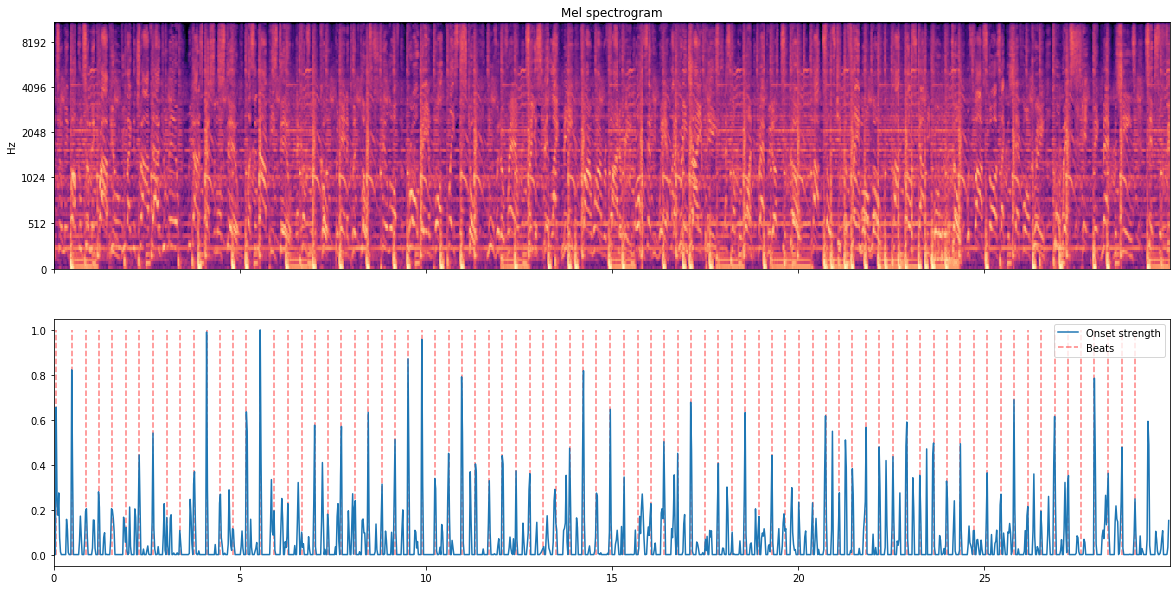

In [5]:
# calculate beats for the loaded file
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute\n\n'.format(tempo))

hop_length = 512
# calculate the strength of the spectral envelope spectral flux
onset_env = librosa.onset.onset_strength(y, sr=sr, aggregate=np.median)
times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)

# calculate the melspectrogram
M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)

fig, ax = plt.subplots(nrows=2, sharex=True)
# plot melspectrogram
librosa.display.specshow(librosa.power_to_db(M, ref=np.max), y_axis='mel', x_axis='time', hop_length=hop_length, ax=ax[0])
ax[0].label_outer()
ax[0].set(title='Mel spectrogram')
# plot onset envelope
ax[1].plot(times, librosa.util.normalize(onset_env), label='Onset strength')
# plot beats
ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
ax[1].legend()

fig.show()

## Spectral Centroid

Calculating the spectral centroid is as easy as the zcr.  
You just need the sampling rate.

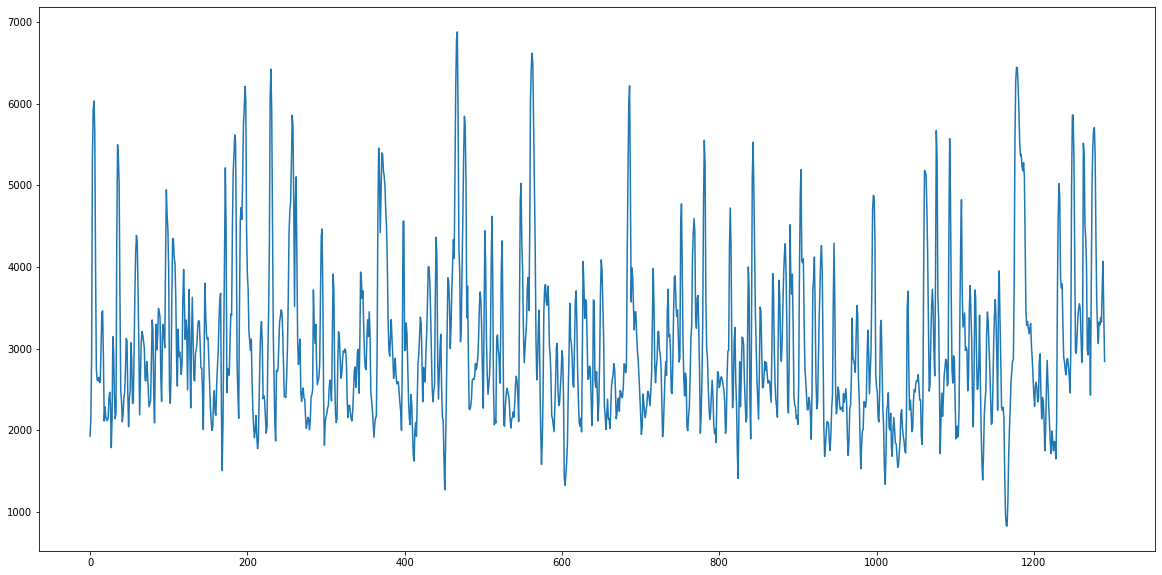

In [6]:
cent = librosa.feature.spectral_centroid(y=y, sr=sr)

plt.plot(cent[0])
plt.show()

# Spectrogram + Spectral Centroid

Spectrograms can be calculated using the stft function.  
Afterward, it is possible to filter and improve the visualization of it.  
The example below shows the spectral centroid and the spectrogram of the loaded song in one plot.  
  
https://librosa.org/doc/latest/generated/librosa.feature.spectral_centroid.html#librosa.feature.spectral_centroid

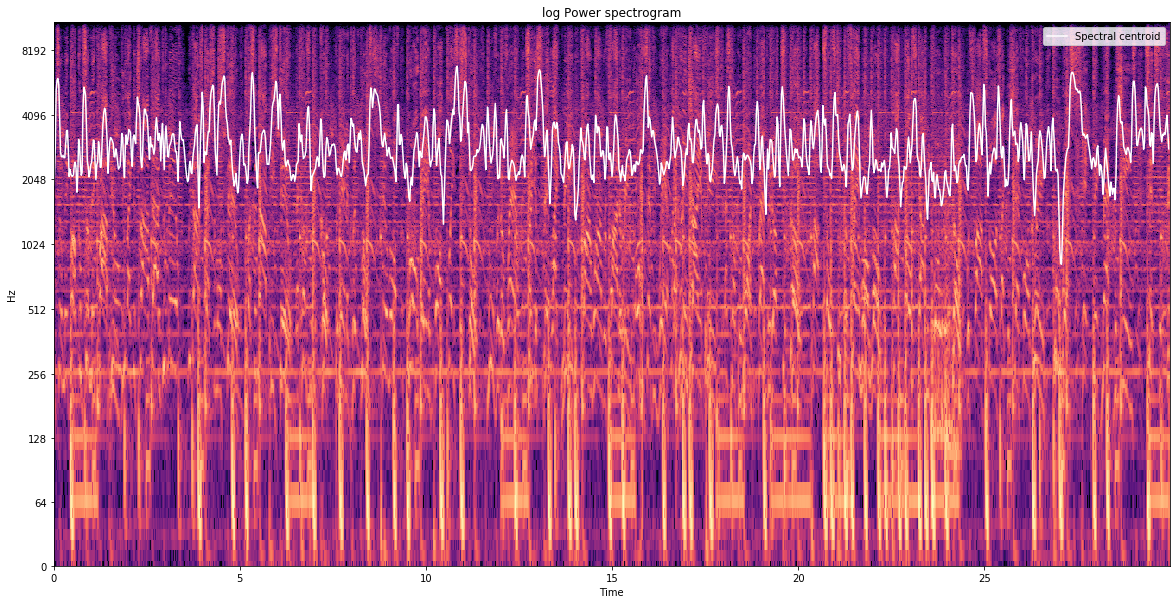

In [7]:
# spectral centroid
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
times = librosa.times_like(cent)

# spectrogram
S, phase = librosa.magphase(librosa.stft(y=y))

fig, ax = plt.subplots()
# plot spectrogram using librosa plot features
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax)
# plot spectral centroid using times to scale the centroid to the spectrogram
ax.plot(times, cent.T, label='Spectral centroid', color='w')
ax.legend(loc='upper right')
ax.set(title='log Power spectrogram')
fig.show()

# Spectrogram + Spectral Bandwidth

The same as above with spectral bandwith within a spectrogram.  
  
  https://librosa.org/doc/latest/generated/librosa.feature.spectral_bandwidth.html#librosa.feature.spectral_bandwidth

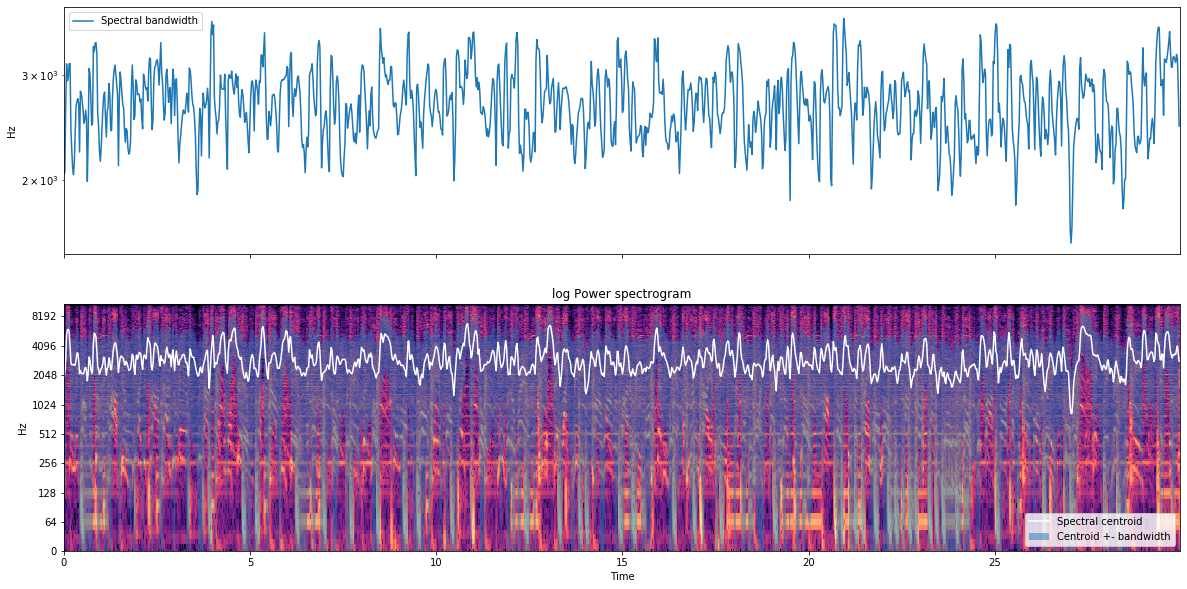

In [8]:
# calculate spectral bandwidth and extract times
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
times = librosa.times_like(spec_bw)

# calculate the spectgrogram
S, phase = librosa.magphase(librosa.stft(y=y))

# calculate centroid based on the spectrogram
centroid = librosa.feature.spectral_centroid(S=S)

fig, ax = plt.subplots(nrows=2, sharex=True)
# plot sepctral bandwidth
ax[0].semilogy(times, spec_bw[0], label='Spectral bandwidth')
ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax[0].legend()
ax[0].label_outer()
# plot spectrogram
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
# plot spectral bandwidth fixed on the spectral centroid
ax[1].fill_between(times, centroid[0] - spec_bw[0], centroid[0] + spec_bw[0], alpha=0.5, label='Centroid +- bandwidth')
# plot the spectral centroid
ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
ax[1].legend(loc='lower right')
fig.show()

# STFT Calculation Example

Another spectrogram example with other forms of spectrograms.

https://librosa.org/doc/latest/auto_examples/plot_hprss.html#sphx-glr-auto-examples-plot-hprss-py

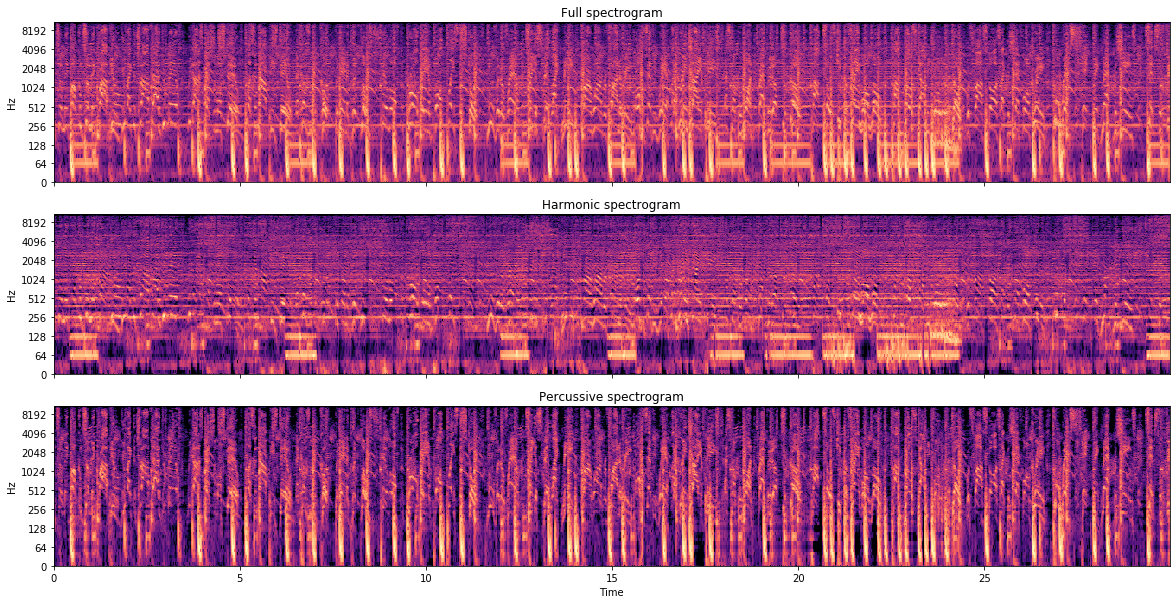

In [9]:
D = librosa.stft(y)

D_harmonic, D_percussive = librosa.decompose.hpss(D)

# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(D))

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)

img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=rp), y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Full spectrogram')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic), ref=rp), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Harmonic spectrogram')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive), ref=rp), y_axis='log', x_axis='time', ax=ax[2])
ax[2].set(title='Percussive spectrogram')

fig.show()

# MFCC

MFCC is as easy calculated as a spectrogram.

https://librosa.org/doc/latest/generated/librosa.feature.mfcc.html#librosa.feature.mfcc

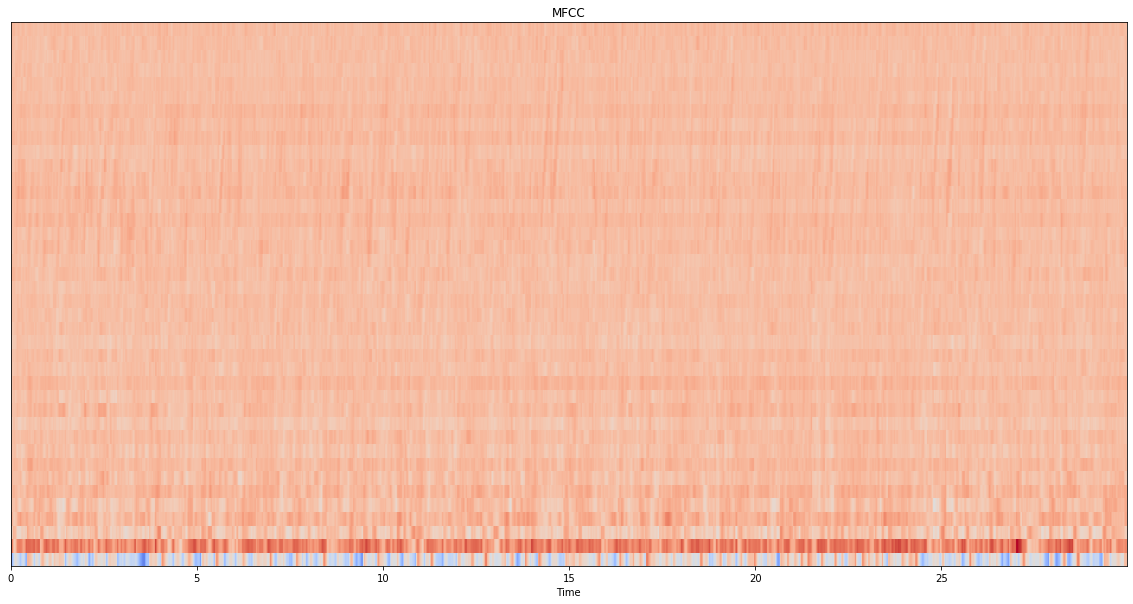

In [10]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
ax.set(title='MFCC')
fig.show()